## SUMMARY

Initial `Makemore` langugae models used - 
* `Bigram statistics`
* `MLP`

But, botht took only took 1 char of prior context - 
* We can add `block_size` (e.g., =3) chars to predict the next

We extend the NN w/ a few tricks -
* `Lookup`: More chars as context
* `Model capacity`: Embedding and channels 
* `Length of running`: Total steps
* `Batch size`: Better gradient (faster convergence)
* `LR schedule`: Tune step sizes (lower) as model gets better 

Note, with mini-batches -
* The gradient quality is lower.
* But, better to have an `approximate gradient and take many steps` ...
* ... than an `exact gradient and take fewer steps`.

Also, we simplify the loss using `cross_entropy` rather than NLL -

* Before, we used softmax layer to compute probabilities from raw logits 
* Then we compute NLL loss from raw probabilities
* `Cross entropy` loss just rolls these all into one step:
* `loss_=F.cross_entropy(logits,Y[ix])`

See:

https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81#:~:text=Negative%20log%2Dlikelihood%20minimization%20is,up%20the%20correct%20log%20probabilities.%E2%80%9D

Note: Our prior model was pretty bad!

It only took 1 char of prior context.

But, our table grows exponentially as we add more chars. 

Yet, our table grows exponentially if we extend the context: `27`, `27^2`, `27^3` prior combinations

So, let's use an MLP to predict the next char (or token) in the sequence: 

* 17k words
* Embed each in a 30d space 
* Train such that words with similar meanings end up in a similar place in the space

Maximize the log-likelihood of the training data.

Example: 

`"A dog was running in a __"`
 
Embedding for `A` and `The` are interchangable.

Or `dog` and `cat` are both animals. 

So, we can share information through embeddings.

Inputs: 
    
* 3 previous worlds out of 17k word vocabulary
* Each word looks up embedding in matrix `C` of length `30`
* Hidden layer w/ `N` neurons, each fully connected to `30 * 3 = 90` input embedding
* Final layer outputs `17k` logits followed by `Softmax` (normalize, sum to 1) 
* Gives probability distribution of next word in sequence

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# Context length: how many characters do we take to predict the next one?
block_size = 3 

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_size
    # Iterate over all chars
    for ch in w + '.':
      ix = stoi[ch]
      # Input: Rolling window of context before char 
      X.append(context)
      # Target: Current char 
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

So, from the `5 words` we have a dataset of:
     
* `32` examples
* Each input is `3` ints
* `Y` is 1 int

We have 27 possible chars:
 
* Let's embed them into a `2d` space
* One hot data type is long (64-bit int)
* Must cast a float to multiply 

Embed a single int `5`:

In [8]:
# Embedding matrix 
C = torch.randn(27,2)
# Index
print(C[5])
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ C)

tensor([ 0.5355, -1.5712])
tensor([ 0.5355, -1.5712])


In [24]:
# We can embed all training inputs simultanously
emb = C[X]

In [25]:
# 100 neurons fully connected to 3 inputs, each embedded to dim 2
W1 = torch.randn(6,100)
b1 = torch.randn(100)

In [26]:
C.shape

torch.Size([27, 2])

In [22]:
# Fails! 
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 228146x100)

Note that we need to re-shape the input!

In [27]:
# Embedding for all first, second, third chars concat
# Does not generalize if we have more than 3 words
torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :]],axis=1).shape

torch.Size([228146, 6])

In [28]:
# So we can drop a tensor dim 
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

Tensors are always 1D vector in computer memory.

See this blog post: http://blog.ezyang.com/2019/05/pytorch-internals/

In [29]:
a = torch.arange(18)
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 18]

We can use `.view` to reshape the 1D sequence!

Using `-1` will infer the size of the dim.

We can use this to perform our origional matrix multiplication.
 
This is efficient b/c it does not create a new Tensor, but `torch.cat(torch.unbind(emb,1),1)` does!

In [30]:
a.view(-1,6).shape

torch.Size([3, 6])

Now, let's create the neural network.

In [31]:
# Dataset
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [205]:
# Splits
import random 
random.seed(42)
n1=int(0.8*len(words))
n2=int(0.9*len(words))
Xtr,Ytr=build_dataset(words[1:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182572, 3]) torch.Size([182572])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [32]:
# Initialize the model
g = torch.Generator().manual_seed(2147483647)  
# Embedding matrix 
# embedding_size=2
embedding_size=10
C = torch.randn((27,embedding_size),generator=g)
# Weights
hidden_in=3*embedding_size
W1 = torch.randn((hidden_in,200),generator=g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

A few tricks -

1/ Let's process `mini-batches` of data, specified by: 

`ix = torch.randint(0,X.shape[0],(32,))`

With minibatch, the gradient quality is lower.

But, better to have an `approximate gradient and take many steps` ...

... than an `exact gradient and take fewer steps`!

2/ `Learning rate`

See below.

3/ `Size`
 
e.g., Bump from `100` to `300` channels.

In [207]:
# Candidate learning rates
lre = torch.linspace(-3,0,1000)
# Start very low, and grow to 1
lrs = 10**lre

In [212]:
# Use train
X = Xtr
Y = Ytr

# Store
lri=[]
lossi=[]
stepi=[]

In [213]:
# Decay LR
lr_decay=[0.1,0.05,0.01]
for lr in lr_decay:

    # Iterate through batches 
    for i in range(50000):

        # Minibatch
        ix = torch.randint(0,X.shape[0],(32,))

        # Embed each element in input
        # X is 228146, 3
        # C on each element in X embeds to 2d
        emb=C[X[ix]] # [32, 3, 2]

        # Neural network 
        # Re-shape embedding to 6 
        h = torch.tanh(emb.view(-1,hidden_in) @ W1 + b1)
        logits = h @ W2 + b2

        # Manual loss 
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdims=True)
        num_chars = prob.shape[0]
        loss=-prob[torch.arange(num_chars),Y[ix]].log().mean()

        # Loss 
        # Smarter b/c PyT will not create all these intermediate tensors
        # Forward pass:  
        # Backward pass: Simpler to implement  
        loss_=F.cross_entropy(logits,Y[ix])

        # Backprop
        for p in parameters:
            p.grad = None
        loss_.backward()

        # LR
        # lr=0.1
        # lr=lrs[i]
        # lri.append(lre[i])
        # Plot log(loss) to squash the hockey stick loss curve
        lossi.append(loss_.log10().item())
        stepi.append(i)

        # Update
        for p in parameters:
            p.data += -lr*p.grad 

    print(loss_.item())

2.105215549468994
2.1685287952423096
2.304079294204712


`Loss curve` - 
* Noise b/c we are optimizing mini-batches.
* If batch size is too low, the gradient is too inaccurate.
* Increace the batch size to obtain a high quality gradient.

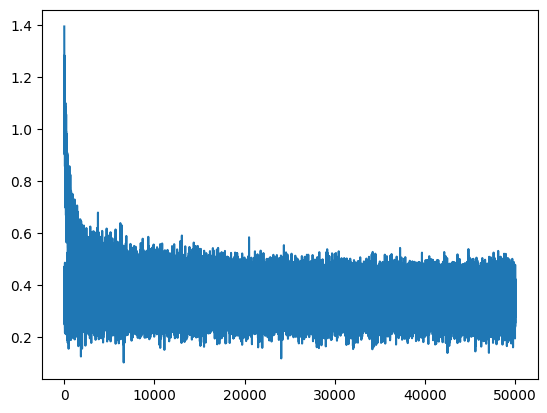

In [214]:
plt.plot(stepi,lossi)

Pick the best `learning rate` - 

* Around `0.1` is good to start
* Then, we model improves w/ successive rounds of training ...
* ... reduce LR further to `0.05` and `0.01`

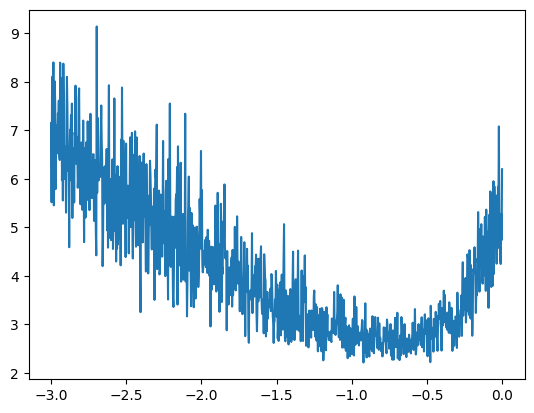

In [154]:
plt.plot(lri,lossi)

Similar loss btwn `dev` and `train`, so model is not overfitting!

Dev and test loss get better after we reduce `LR` and increace the channel count.

In [216]:
# Train loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,hidden_in) @ W1 + b1)
logits = h @ W2 + b2
loss_tr=F.cross_entropy(logits,Ytr)
loss_tr

tensor(2.1440, grad_fn=<NllLossBackward0>)

In [217]:
# Dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,hidden_in) @ W1 + b1)
logits = h @ W2 + b2
loss_dev=F.cross_entropy(logits,Ydev)
loss_dev

tensor(2.1901, grad_fn=<NllLossBackward0>)

We suspect under-fitting - 

* We made channels larger, but did not see improvement in loss / dev or test error.

Visualize embeddings to see if this is sane - 

* Some structure to the embeddings. 
* X and Y coord as embedding location. 
* Seperate and cluster chars: vowels cluster. Similar embedding for each. `Interchangable`.

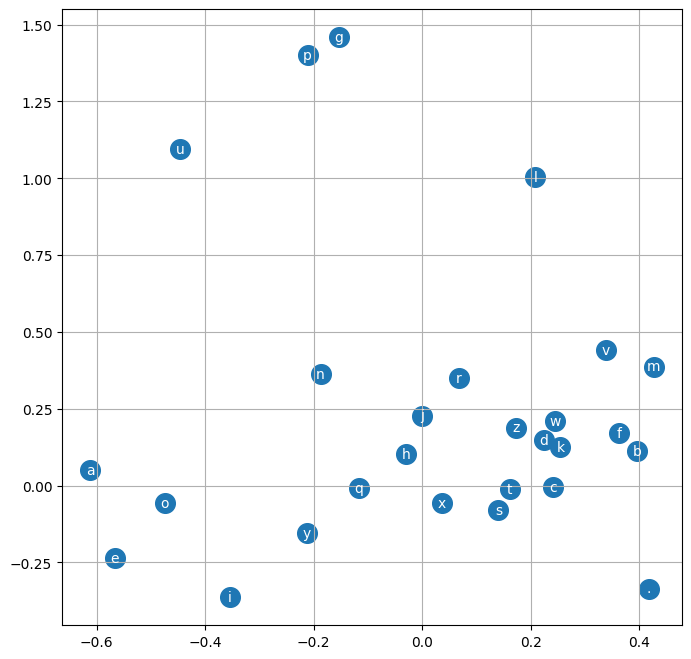

In [196]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Ways to improve - 
 
* `Lookup`: More chars as context
* `Model capacity`: Embedding and channels 
* `Length of running`: Total steps
* `Batch size`: Better gradient (faster convergence)
* `LR schedule`: Tune step sizes (lower) as model gets better 

One thing to watch:
    
We can get `inf` if we run out of dynamic range in floating point numbers.

`e^100` is outside the dynamtic range of FP, so we get `int`.

Any offset to logits will produce the same value due to normalization.

So, under the hood Pytorch finds the maximum `logit` value and subtracts it.

In [103]:
logits = torch.tensor([-100,-3,0,100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])